[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Loading A/D line data from nyse_breadth_2023.csv...
Data summary:
- Time period: 2018-04-04 00:00:00 to 2025-04-22 00:00:00
- Number of trading days: 1773
- Number of features calculated: 107
Using 102 features for SOM analysis
Training SOM with dimensions 15x15 for 10000 iterations
Training SOM...
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 6.230195813370571


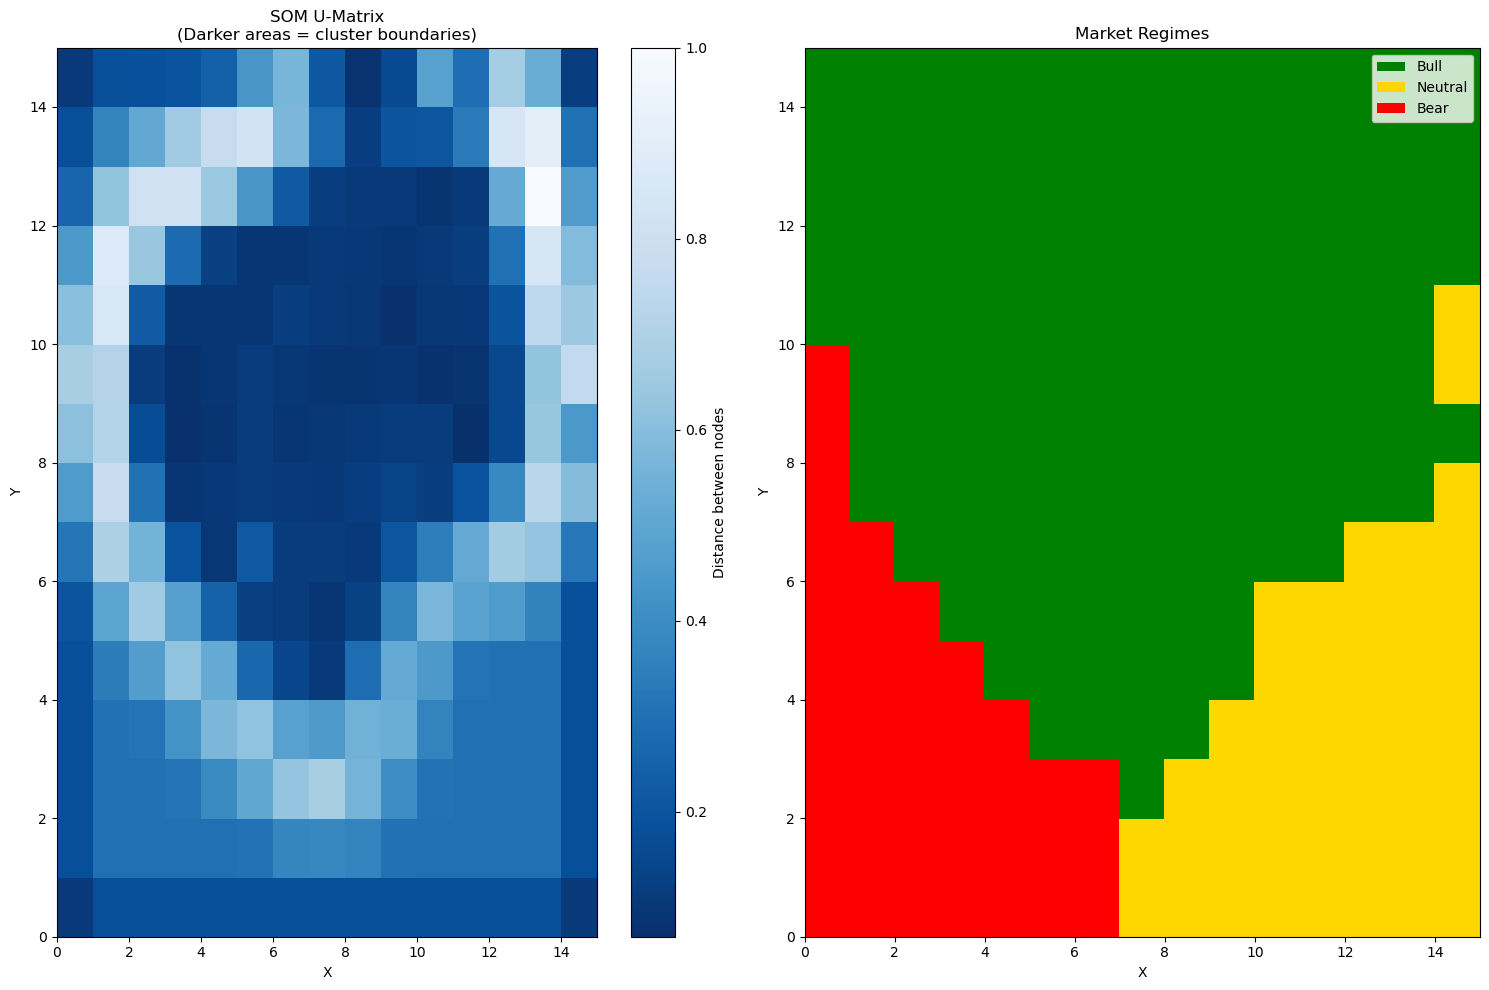

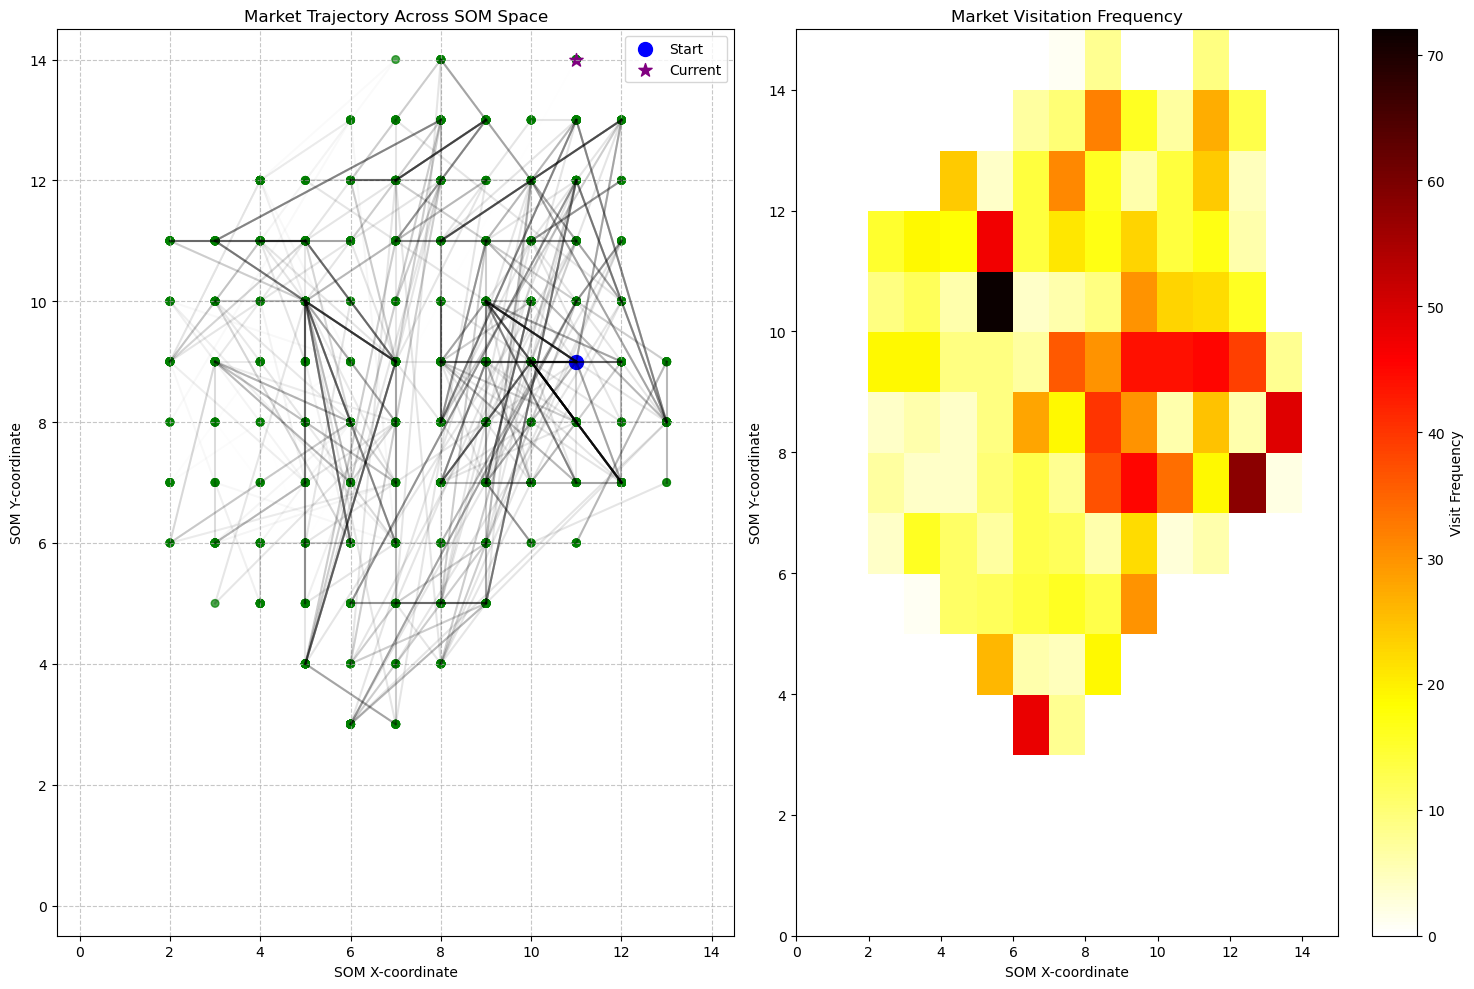

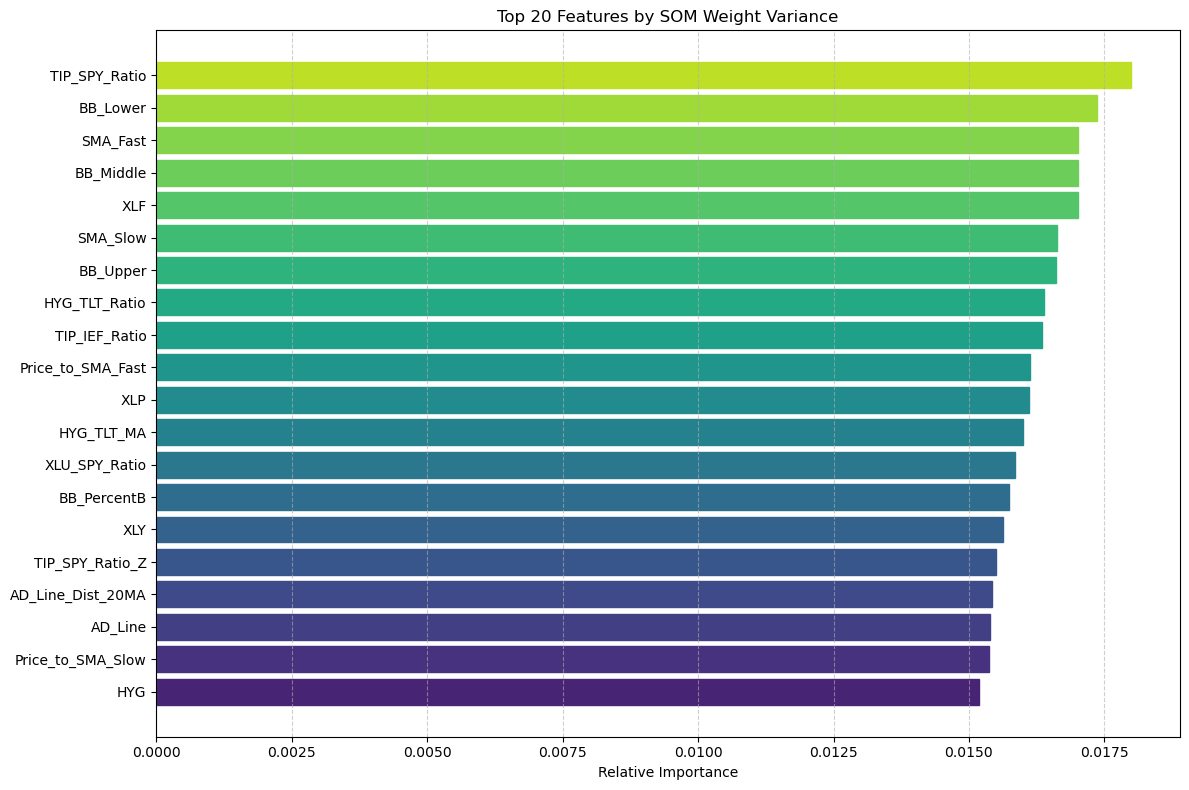


Regime Transitions:
Bull (current): 2018-04-04 to 2025-04-22 (2575 days)

Regime Performance Summary:
Regime   Days  Ann. Return %  Ann. Vol %  Sharpe Ratio  Hit Rate %  Max Drawdown %  Avg VIX
  Bull 1773.0           11.6       20.07          0.58       55.05          -35.75    20.04

Top 10 Most Important Features:
1. TIP_SPY_Ratio: 0.0180
2. BB_Lower: 0.0174
3. SMA_Fast: 0.0170
4. BB_Middle: 0.0170
5. XLF: 0.0170
6. SMA_Slow: 0.0166
7. BB_Upper: 0.0166
8. HYG_TLT_Ratio: 0.0164
9. TIP_IEF_Ratio: 0.0163
10. Price_to_SMA_Fast: 0.0161


In [1]:
# Ensure these imports are at the top of your script
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
import yfinance as yf
from datetime import datetime, timedelta
import warnings
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
import seaborn as sns
from minisom import MiniSom
warnings.filterwarnings('ignore')


# ======== CONFIGURABLE PARAMETERS ========
# Market data parameters
TICKER = 'SPY'  # Main ticker to analyze
VIX_TICKER = '^VIX'  # Volatility index
TNX_TICKER = '^TNX'  # 10-Year Treasury Yield
GLD_TICKER = 'GLD'  # Gold ETF
XLY_TICKER = 'XLY'  # Consumer Discretionary ETF
XLP_TICKER = 'XLP'  # Consumer Staples ETF
XLU_TICKER = 'XLU'  # Utilities ETF
XLF_TICKER = 'XLF'  # Financial ETF
HYG_TICKER = 'HYG'  # High Yield Corporate Bond ETF
TLT_TICKER = 'TLT'  # 20+ Year Treasury Bond ETF
VIX3M_TICKER = '^VIX3M'  # 3-Month VIX
IRX_TICKER = '^IRX'  # 2-Year Treasury Yield
UUP_TICKER = 'UUP'  # US Dollar Index ETF
TIP_TICKER = 'TIP'  # TIPS ETF
IEF_TICKER = 'IEF'  # 7-10 Year Treasury ETF
START_DATE = "2018-01-01"  # Historical data start date
END_DATE = "2025-04-25"    # Data end date (updated to latest)

# SOM model parameters
SOM_X_DIM = 15  # SOM grid width
SOM_Y_DIM = 15  # SOM grid height
SOM_ITERATIONS = 10000  # Training iterations
SOM_SIGMA = 0.7  # Initial neighborhood radius
SOM_LEARNING_RATE = 0.8  # Initial learning rate
NUM_REGIMES = 3  # Number of market regimes to identify

# Technical indicator parameters
VOL_WINDOW = 21  # Window for volatility calculation (21 days ~ 1 month)
MOMENTUM_WINDOW = 63  # Window for momentum calculation (63 days ~ 3 months)
SMA_FAST = 20  # Fast moving average
SMA_SLOW = 50  # Slow moving average
BB_WINDOW = 20  # Bollinger Bands window
BB_STD = 2  # Bollinger Bands standard deviation multiplier
ATR_WINDOW = 14  # Average True Range window
CHOP_WINDOW = 14  # Choppiness Index window
SECTOR_WINDOW = 10  # Window for sector rotation indicators
CREDIT_MA_WINDOW = 30  # Window for credit spread MA

# ======== DATA PREPARATION FUNCTIONS ========

def load_ad_line_data(filepath="nyse_breadth_2023.csv"):
    """Load and prepare NYSE breadth data for A/D line indicators"""
    print(f"Loading A/D line data from {filepath}...")
    
    # Read the CSV file
    ad_data = pd.read_csv(filepath)
    
    # Convert the date column to datetime
    ad_data['Date'] = pd.to_datetime(ad_data['Date'])
    
    # Calculate basic breadth metrics
    # 1. Cumulative A/D Line
    ad_data['Net_Advances'] = ad_data['Advancers'] - ad_data['Decliners']
    ad_data['AD_Line'] = ad_data['Net_Advances'].cumsum()
    
    # 2. A/D Ratio and Z-Score
    ad_data['AD_Ratio'] = ad_data['Advancers'] / ad_data['Decliners']
    ad_data['Log_AD_Ratio'] = np.log(ad_data['AD_Ratio'])
    ad_data['Log_AD_Ratio_21d_Mean'] = ad_data['Log_AD_Ratio'].rolling(window=21).mean()
    ad_data['Log_AD_Ratio_21d_StdDev'] = ad_data['Log_AD_Ratio'].rolling(window=21).std()
    ad_data['AD_Ratio_Z_Score'] = (ad_data['Log_AD_Ratio'] - ad_data['Log_AD_Ratio_21d_Mean']) / ad_data['Log_AD_Ratio_21d_StdDev']
    
    # 3. McClellan Oscillator
    # Calculate EMAs of Net Advances
    ad_data['EMA19_Net_Advances'] = ad_data['Net_Advances'].ewm(span=19, adjust=False).mean()
    ad_data['EMA39_Net_Advances'] = ad_data['Net_Advances'].ewm(span=39, adjust=False).mean()
    ad_data['McClellan_Oscillator'] = ad_data['EMA19_Net_Advances'] - ad_data['EMA39_Net_Advances']
    # Normalize by total issues
    ad_data['Total_Issues'] = ad_data['Advancers'] + ad_data['Decliners'] + ad_data['Neutral']
    ad_data['McClellan_Oscillator_Norm'] = ad_data['McClellan_Oscillator'] / (ad_data['Total_Issues']) * 1000
    
    # 4. Percentage of Advancing Issues
    ad_data['Advancing_Percentage'] = ad_data['Advancers'] / ad_data['Total_Issues'] * 100
    ad_data['Advancing_Percentage_10MA'] = ad_data['Advancing_Percentage'].rolling(window=10).mean()
    ad_data['Advancing_Percentage_Z'] = (ad_data['Advancing_Percentage'] - ad_data['Advancing_Percentage'].rolling(window=21).mean()) / ad_data['Advancing_Percentage'].rolling(window=21).std()
    
    # 5. Breadth Thrust Indicator
    ad_data['Daily_Thrust'] = ad_data['Advancers'] / (ad_data['Advancers'] + ad_data['Decliners'])
    ad_data['Breadth_Thrust'] = ad_data['Daily_Thrust'].ewm(span=10, adjust=False).mean()
    ad_data['Thrust_Signal'] = (ad_data['Breadth_Thrust'] > 0.65).astype(int)
    
    # 6. McClellan Summation Index
    ad_data['McClellan_Summation_Index'] = ad_data['McClellan_Oscillator'].cumsum()
    ad_data['McClellan_SI_10MA'] = ad_data['McClellan_Summation_Index'].rolling(window=10).mean()
    
    # 7. A/D Line Momentum
    ad_data['AD_Line_5d_ROC'] = ad_data['AD_Line'].pct_change(periods=5) * 100
    ad_data['AD_Line_10d_ROC'] = ad_data['AD_Line'].pct_change(periods=10) * 100
    ad_data['AD_Line_20d_ROC'] = ad_data['AD_Line'].pct_change(periods=20) * 100
    ad_data['AD_Line_Momentum_Z'] = (ad_data['AD_Line_10d_ROC'] - ad_data['AD_Line_10d_ROC'].rolling(window=50).mean()) / ad_data['AD_Line_10d_ROC'].rolling(window=50).std()
    
    # 8. A/D Line Moving Average Crossovers
    ad_data['AD_Line_20MA'] = ad_data['AD_Line'].rolling(window=20).mean()
    ad_data['AD_Line_50MA'] = ad_data['AD_Line'].rolling(window=50).mean()
    ad_data['AD_Line_Golden_Cross'] = (ad_data['AD_Line_20MA'] > ad_data['AD_Line_50MA']).astype(int)
    ad_data['AD_Line_Dist_20MA'] = (ad_data['AD_Line'] / ad_data['AD_Line_20MA'] - 1) * 100
    
    # 9. Composite Breadth Indicator
    # Normalize each component to range [0,1]
    ad_data['AD_Ratio_Z_Norm'] = (ad_data['AD_Ratio_Z_Score'].clip(-3, 3) + 3) / 6
    ad_data['McClellan_Osc_Norm'] = (ad_data['McClellan_Oscillator'].clip(-150, 150) + 150) / 300
    ad_data['Breadth_Thrust_Norm'] = ad_data['Breadth_Thrust']
    ad_data['Advancing_Pct_Norm'] = ad_data['Advancing_Percentage'] / 100
    
    # Create composite
    ad_data['Composite_Breadth'] = (ad_data['AD_Ratio_Z_Norm'] + 
                                   ad_data['McClellan_Osc_Norm'] + 
                                   ad_data['Breadth_Thrust_Norm'] + 
                                   ad_data['Advancing_Pct_Norm']) / 4
    
    ad_data['Composite_Breadth_Z'] = (ad_data['Composite_Breadth'] - 
                                     ad_data['Composite_Breadth'].rolling(window=50).mean()) / ad_data['Composite_Breadth'].rolling(window=50).std().fillna(1)
    
    return ad_data

def download_market_data(ticker, vix_ticker, tnx_ticker, gld_ticker, xly_ticker, xlp_ticker, xlu_ticker, xlf_ticker, hyg_ticker, tlt_ticker, start_date, end_date=None):
    """Download and prepare market data"""
    if end_date is None:
        end_date = (datetime.today() + timedelta(days=1)).strftime("%Y-%m-%d")
    print(f"Downloading market data from {start_date} to {end_date}...")
    
    # Download ticker, VIX, TNX, GLD, sector ETFs, and bond ETF data
    df_ticker = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)
    df_vix = yf.download(vix_ticker, start=start_date, end=end_date)
    df_tnx = yf.download(tnx_ticker, start=start_date, end=end_date)
    df_gld = yf.download(gld_ticker, start=start_date, end=end_date)
    df_xly = yf.download(xly_ticker, start=start_date, end=end_date)
    df_xlp = yf.download(xlp_ticker, start=start_date, end=end_date)
    df_xlu = yf.download(xlu_ticker, start=start_date, end=end_date)
    df_xlf = yf.download(xlf_ticker, start=start_date, end=end_date)
    df_hyg = yf.download(hyg_ticker, start=start_date, end=end_date)
    df_tlt = yf.download(tlt_ticker, start=start_date, end=end_date)
    
    # Download additional tickers for new features
    df_vix3m = yf.download(VIX3M_TICKER, start=start_date, end=end_date)
    df_irx = yf.download(IRX_TICKER, start=start_date, end=end_date)
    df_uup = yf.download(UUP_TICKER, start=start_date, end=end_date)
    df_tip = yf.download(TIP_TICKER, start=start_date, end=end_date)
    df_ief = yf.download(IEF_TICKER, start=start_date, end=end_date)
    
    # Fix column structure and reset index
    if len(df_ticker.columns.names) > 1:
        df_ticker.columns = df_ticker.columns.droplevel(1)
    if len(df_vix.columns.names) > 1:
        df_vix.columns = df_vix.columns.droplevel(1)
    if len(df_tnx.columns.names) > 1:
        df_tnx.columns = df_tnx.columns.droplevel(1)
    if len(df_gld.columns.names) > 1:
        df_gld.columns = df_gld.columns.droplevel(1)
    if len(df_xly.columns.names) > 1:
        df_xly.columns = df_xly.columns.droplevel(1)
    if len(df_xlp.columns.names) > 1:
        df_xlp.columns = df_xlp.columns.droplevel(1)
    if len(df_xlu.columns.names) > 1:
        df_xlu.columns = df_xlu.columns.droplevel(1)
    if len(df_xlf.columns.names) > 1:
        df_xlf.columns = df_xlf.columns.droplevel(1)
    if len(df_hyg.columns.names) > 1:
        df_hyg.columns = df_hyg.columns.droplevel(1)
    if len(df_tlt.columns.names) > 1:
        df_tlt.columns = df_tlt.columns.droplevel(1)
    
    # Fix column structure for new tickers
    if len(df_vix3m.columns.names) > 1:
        df_vix3m.columns = df_vix3m.columns.droplevel(1)
    if len(df_irx.columns.names) > 1:
        df_irx.columns = df_irx.columns.droplevel(1)
    if len(df_uup.columns.names) > 1:
        df_uup.columns = df_uup.columns.droplevel(1)
    if len(df_tip.columns.names) > 1:
        df_tip.columns = df_tip.columns.droplevel(1)
    if len(df_ief.columns.names) > 1:
        df_ief.columns = df_ief.columns.droplevel(1)
    
    df_ticker = df_ticker.reset_index()
    df_vix = df_vix.reset_index()
    df_tnx = df_tnx.reset_index()
    df_gld = df_gld.reset_index()
    df_xly = df_xly.reset_index()
    df_xlp = df_xlp.reset_index()
    df_xlu = df_xlu.reset_index()
    df_xlf = df_xlf.reset_index()
    df_hyg = df_hyg.reset_index()
    df_tlt = df_tlt.reset_index()
    
    df_vix3m = df_vix3m.reset_index()
    df_irx = df_irx.reset_index()
    df_uup = df_uup.reset_index()
    df_tip = df_tip.reset_index()
    df_ief = df_ief.reset_index()
    
    # Keep only Date and Close from VIX
    df_vix = df_vix[['Date', 'Close']].rename(columns={'Close': 'VIX'})
    
    # Keep only Date and Close from TNX
    df_tnx = df_tnx[['Date', 'Close']].rename(columns={'Close': 'TNX'})
    
    # Keep only relevant columns from GLD, sector ETFs, and bond ETFs
    df_gld = df_gld[['Date', 'Close']].rename(columns={'Close': 'GLD'})
    df_xly = df_xly[['Date', 'Close']].rename(columns={'Close': 'XLY'})
    df_xlp = df_xlp[['Date', 'Close']].rename(columns={'Close': 'XLP'})
    df_xlu = df_xlu[['Date', 'Close']].rename(columns={'Close': 'XLU'})
    df_xlf = df_xlf[['Date', 'Close']].rename(columns={'Close': 'XLF'})
    df_hyg = df_hyg[['Date', 'Close']].rename(columns={'Close': 'HYG'})
    df_tlt = df_tlt[['Date', 'Close']].rename(columns={'Close': 'TLT'})
    
    # Keep only relevant columns from new tickers
    df_vix3m = df_vix3m[['Date', 'Close']].rename(columns={'Close': 'VIX3M'})
    df_irx = df_irx[['Date', 'Close']].rename(columns={'Close': 'IRX'})
    df_uup = df_uup[['Date', 'Close']].rename(columns={'Close': 'UUP'})
    df_tip = df_tip[['Date', 'Close']].rename(columns={'Close': 'TIP'})
    df_ief = df_ief[['Date', 'Close']].rename(columns={'Close': 'IEF'})
    
    # Merge data
    df = pd.merge(df_ticker, df_vix, on='Date', how='left')
    df = pd.merge(df, df_tnx, on='Date', how='left')
    df = pd.merge(df, df_gld, on='Date', how='left')
    df = pd.merge(df, df_xly, on='Date', how='left')
    df = pd.merge(df, df_xlp, on='Date', how='left')
    df = pd.merge(df, df_xlu, on='Date', how='left')
    df = pd.merge(df, df_xlf, on='Date', how='left')
    df = pd.merge(df, df_hyg, on='Date', how='left')
    df = pd.merge(df, df_tlt, on='Date', how='left')
    
    # Merge new tickers
    df = pd.merge(df, df_vix3m, on='Date', how='left')
    df = pd.merge(df, df_irx, on='Date', how='left')
    df = pd.merge(df, df_uup, on='Date', how='left')
    df = pd.merge(df, df_tip, on='Date', how='left')
    df = pd.merge(df, df_ief, on='Date', how='left')
    
    # Fill missing values with forward fill method
    df['VIX'] = df['VIX'].fillna(method='ffill')
    df['TNX'] = df['TNX'].fillna(method='ffill')
    df['GLD'] = df['GLD'].fillna(method='ffill')
    df['XLY'] = df['XLY'].fillna(method='ffill')
    df['XLP'] = df['XLP'].fillna(method='ffill')
    df['XLU'] = df['XLU'].fillna(method='ffill')
    df['XLF'] = df['XLF'].fillna(method='ffill')
    df['HYG'] = df['HYG'].fillna(method='ffill')
    df['TLT'] = df['TLT'].fillna(method='ffill')
    
    # Fill missing values for new tickers
    df['VIX3M'] = df['VIX3M'].fillna(method='ffill')
    df['IRX'] = df['IRX'].fillna(method='ffill')
    df['UUP'] = df['UUP'].fillna(method='ffill')
    df['TIP'] = df['TIP'].fillna(method='ffill')
    df['IEF'] = df['IEF'].fillna(method='ffill')
    
    # Calculate daily log returns
    df['LogVIX'] = np.log(df['VIX'])
    df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1)) * 100
    df['GLD_Log_Return'] = np.log(df['GLD'] / df['GLD'].shift(1)) * 100
    
    return df

def calculate_bollinger_bands(df, window=20, num_std=2):
    """Calculate Bollinger Bands and related metrics"""
    # Calculate Bollinger Bands
    df['BB_Middle'] = df['Close'].rolling(window=window).mean()
    rolling_std = df['Close'].rolling(window=window).std()
    df['BB_Upper'] = df['BB_Middle'] + (rolling_std * num_std)
    df['BB_Lower'] = df['BB_Middle'] - (rolling_std * num_std)
    
    # Calculate Bollinger Band Width (normalized)
    df['BB_Width'] = (df['BB_Upper'] - df['BB_Lower']) / df['BB_Middle'] * 100
    
    # Calculate %B (position within the bands)
    df['BB_PercentB'] = (df['Close'] - df['BB_Lower']) / (df['BB_Upper'] - df['BB_Lower'])
    
    return df

def calculate_atr(df, window=14):
    """Calculate Average True Range (ATR)"""
    # Calculate True Range
    df['TR1'] = abs(df['High'] - df['Low'])
    df['TR2'] = abs(df['High'] - df['Close'].shift(1))
    df['TR3'] = abs(df['Low'] - df['Close'].shift(1))
    df['True_Range'] = df[['TR1', 'TR2', 'TR3']].max(axis=1)
    
    # Calculate ATR using Wilder's smoothing method
    df['ATR'] = df['True_Range'].rolling(window=window).mean()
    
    # Normalize ATR by price
    df['ATR_Normalized'] = df['ATR'] / df['Close'] * 100
    
    # Clean up intermediate columns
    df = df.drop(['TR1', 'TR2', 'TR3'], axis=1)
    
    return df

def calculate_choppiness_index(df, window=14):
    """Calculate Choppiness Index"""
    if 'ATR' not in df.columns:
        df = calculate_atr(df, window)
    
    df['MaxHi'] = df['High'].rolling(window=window).max()
    df['MinLo'] = df['Low'].rolling(window=window).min()
    df['ATR_Sum'] = df['ATR'].rolling(window=window).sum()
    
    # Calculate Choppiness Index
    df['Choppiness_Index'] = 100 * np.log10(df['ATR_Sum'] / (df['MaxHi'] - df['MinLo'])) / np.log10(window)
    
    # Clean up intermediate columns
    df = df.drop(['MaxHi', 'MinLo', 'ATR_Sum'], axis=1)
    
    return df

def calculate_features(data, ad_data=None):
    """Calculate ALL features for regime classification, including A/D line indicators"""
    df = data.copy()
    
    # Volatility features
    df['Volatility'] = df['Log_Return'].rolling(window=VOL_WINDOW).std() * np.sqrt(252)  # Annualized
    df['Volume_Z_Score'] = (df['Volume'] - df['Volume'].rolling(window=VOL_WINDOW).mean()) / df['Volume'].rolling(window=VOL_WINDOW).std()
    
    # Trend features
    df['Momentum'] = df['Close'].pct_change(periods=MOMENTUM_WINDOW) * 100
    df['SMA_Fast'] = df['Close'].rolling(window=SMA_FAST).mean()
    df['SMA_Slow'] = df['Close'].rolling(window=SMA_SLOW).mean()
    df['SMA_Ratio'] = df['SMA_Fast'] / df['SMA_Slow']
    
    # Price distance from moving averages
    df['Price_to_SMA_Fast'] = df['Close'] / df['SMA_Fast'] - 1
    df['Price_to_SMA_Slow'] = df['Close'] / df['SMA_Slow'] - 1
    
    # VIX-based features
    df['VIX_Ratio'] = df['VIX'] / df['VIX'].rolling(window=VOL_WINDOW).mean()
    df['VIX_Change'] = df['VIX'].pct_change(periods=5) * 100  # 5-day VIX change
    
    # Treasury Yield (TNX) features
    df['TNX_Level'] = df['TNX']  # Absolute yield level
    df['TNX_Daily_Change'] = df['TNX'].diff() * 100  # Daily change in basis points
    df['TNX_Weekly_Change'] = df['TNX'].diff(5) * 100  # 1-week change in basis points
    df['TNX_Z_Score'] = (df['TNX'] - df['TNX'].rolling(window=VOL_WINDOW).mean()) / df['TNX'].rolling(window=VOL_WINDOW).std()
    df['TNX_Ratio'] = df['TNX'] / df['TNX'].rolling(window=VOL_WINDOW).mean()
    
    # Gold (GLD) features
    if df['GLD'].notna().any():
        df['GLD_Volatility'] = df['GLD_Log_Return'].rolling(window=VOL_WINDOW).std() * np.sqrt(252)
        df['GLD_SPY_Ratio'] = df['GLD'] / df['Close']
        df['GLD_SPY_Ratio_Change'] = df['GLD_SPY_Ratio'].pct_change(periods=5) * 100
        df['GLD_Z_Score'] = (df['GLD'] - df['GLD'].rolling(window=VOL_WINDOW).mean()) / df['GLD'].rolling(window=VOL_WINDOW).std()
        df['GLD_Momentum'] = df['GLD'].pct_change(periods=MOMENTUM_WINDOW) * 100
        df['GLD_SPY_Momentum_Diff'] = df['GLD_Momentum'] - df['Momentum']
    
    # Sector Rotation indicators
    if df['XLY'].notna().any() and df['XLP'].notna().any():
        df['XLY_XLP_Ratio'] = df['XLY'] / df['XLP']
        df['XLY_XLP_Change'] = df['XLY_XLP_Ratio'].pct_change(periods=SECTOR_WINDOW) * 100
        df['XLY_XLP_Z'] = (df['XLY_XLP_Ratio'] - df['XLY_XLP_Ratio'].rolling(window=VOL_WINDOW).mean()) / df['XLY_XLP_Ratio'].rolling(window=VOL_WINDOW).std()
    
    if df['XLU'].notna().any():
        df['XLU_SPY_Ratio'] = df['XLU'] / df['Close']
        df['XLU_SPY_Change'] = df['XLU_SPY_Ratio'].pct_change(periods=SECTOR_WINDOW) * 100
        df['XLU_SPY_Z'] = (df['XLU_SPY_Ratio'] - df['XLU_SPY_Ratio'].rolling(window=VOL_WINDOW).mean()) / df['XLU_SPY_Ratio'].rolling(window=VOL_WINDOW).std()
    
    if df['XLF'].notna().any():
        df['XLF_SPY_Ratio'] = df['XLF'] / df['Close']
        df['XLF_SPY_Change'] = df['XLF_SPY_Ratio'].pct_change(periods=SECTOR_WINDOW) * 100
        df['XLF_SPY_Z'] = (df['XLF_SPY_Ratio'] - df['XLF_SPY_Ratio'].rolling(window=VOL_WINDOW).mean()) / df['XLF_SPY_Ratio'].rolling(window=VOL_WINDOW).std()
    
    # Credit Spread indicators (HYG/TLT)
    if df['HYG'].notna().any() and df['TLT'].notna().any():
        df['HYG_TLT_Ratio'] = df['HYG'] / df['TLT']
        df['HYG_TLT_Daily_Change'] = df['HYG_TLT_Ratio'].pct_change() * 100
        df['HYG_TLT_MA'] = df['HYG_TLT_Ratio'].rolling(window=CREDIT_MA_WINDOW).mean()
        df['HYG_TLT_MA_Diff'] = (df['HYG_TLT_Ratio'] / df['HYG_TLT_MA'] - 1) * 100
        df['HYG_TLT_Z'] = (df['HYG_TLT_Ratio'] - df['HYG_TLT_Ratio'].rolling(window=VOL_WINDOW).mean()) / df['HYG_TLT_Ratio'].rolling(window=VOL_WINDOW).std()
        df['HYG_TLT_Volatility'] = df['HYG_TLT_Daily_Change'].rolling(window=VOL_WINDOW).std()
    
    # Volume features
    df['Volume_Trend'] = df['Volume'] / df['Volume'].rolling(window=VOL_WINDOW).mean()
    df['Volume_to_Volatility'] = df['Volume'] / (df['Volatility'] + 1e-10)
    
    # Combined features
    df['Return_Volatility_Ratio'] = df['Log_Return'] / (df['Volatility'] + 1e-10)
    df['VIX_Volatility_Ratio'] = df['VIX'] / (df['Volatility'] + 1e-10)
    
    # Add Bollinger Bands features
    df = calculate_bollinger_bands(df, window=BB_WINDOW, num_std=BB_STD)
    
    # Add ATR features
    df = calculate_atr(df, window=ATR_WINDOW)
    
    # Add Choppiness Index
    df = calculate_choppiness_index(df, window=CHOP_WINDOW)
    
    # Calculate Z-scores for the new indicators
    df['BB_Width_Z'] = (df['BB_Width'] - df['BB_Width'].rolling(window=VOL_WINDOW).mean()) / df['BB_Width'].rolling(window=VOL_WINDOW).std()
    df['ATR_Norm_Z'] = (df['ATR_Normalized'] - df['ATR_Normalized'].rolling(window=VOL_WINDOW).mean()) / df['ATR_Normalized'].rolling(window=VOL_WINDOW).std()
    df['Choppiness_Z'] = (df['Choppiness_Index'] - df['Choppiness_Index'].rolling(window=VOL_WINDOW).mean()) / df['Choppiness_Index'].rolling(window=VOL_WINDOW).std()
    
    # Add the new features requested by the user
    
    # 1. Yield Curve Spread (10Y-2Y)
    if 'TNX' in df.columns and 'IRX' in df.columns:
        # Calculate the spread in percentage points
        df['Yield_Curve_Spread'] = df['TNX'] - df['IRX']
        
        # Calculate Z-score of the spread
        df['Yield_Curve_Spread_Z'] = (df['Yield_Curve_Spread'] - df['Yield_Curve_Spread'].rolling(window=VOL_WINDOW).mean()) / df['Yield_Curve_Spread'].rolling(window=VOL_WINDOW).std()
        
        # Calculate weekly change in the spread
        df['Yield_Curve_Spread_Change'] = df['Yield_Curve_Spread'].diff(5) * 100  # 1-week change in basis points
        
        # Calculate inversion flag (1 if inverted, 0 if normal)
        df['Yield_Curve_Inverted'] = (df['Yield_Curve_Spread'] < 0).astype(int)
    
    # 2. VIX/VIX3M Ratio (Volatility Term Structure)
    if 'VIX' in df.columns and 'VIX3M' in df.columns:
        # Calculate ratio (values < 1 indicate normal contango, values > 1 indicate backwardation/fear)
        df['VIX_VIX3M_Ratio'] = df['VIX'] / df['VIX3M']
        
        # Calculate Z-score of the ratio
        df['VIX_VIX3M_Ratio_Z'] = (df['VIX_VIX3M_Ratio'] - df['VIX_VIX3M_Ratio'].rolling(window=VOL_WINDOW).mean()) / df['VIX_VIX3M_Ratio'].rolling(window=VOL_WINDOW).std()
        
        # Calculate spread (for alternative representation)
        df['VIX_VIX3M_Spread'] = df['VIX'] - df['VIX3M']
        
        # Flag for backwardation (1 if in backwardation, 0 if in contango)
        df['VIX_Backwardation'] = (df['VIX_VIX3M_Ratio'] > 1).astype(int)
    
    # 3. UUP Z-Score (Dollar Strength)
    if 'UUP' in df.columns:
        # Calculate UUP returns
        df['UUP_Return'] = df['UUP'].pct_change() * 100
        
        # Calculate UUP Z-score (normalized dollar strength)
        df['UUP_Z_Score'] = (df['UUP'] - df['UUP'].rolling(window=VOL_WINDOW).mean()) / df['UUP'].rolling(window=VOL_WINDOW).std()
        
        # Calculate UUP momentum
        df['UUP_Momentum'] = df['UUP'].pct_change(periods=VOL_WINDOW) * 100
        
        # Calculate UUP volatility
        df['UUP_Volatility'] = df['UUP_Return'].rolling(window=VOL_WINDOW).std() * np.sqrt(252)
    
    # 4. TIP/IEF Ratio (Inflation Expectations)
    if 'TIP' in df.columns and 'IEF' in df.columns:
        # Calculate the ratio
        df['TIP_IEF_Ratio'] = df['TIP'] / df['IEF']
        
        # Calculate Z-score of the ratio
        df['TIP_IEF_Ratio_Z'] = (df['TIP_IEF_Ratio'] - df['TIP_IEF_Ratio'].rolling(window=VOL_WINDOW).mean()) / df['TIP_IEF_Ratio'].rolling(window=VOL_WINDOW).std()
        
        # Calculate weekly change in the ratio
        df['TIP_IEF_Ratio_Change'] = df['TIP_IEF_Ratio'].pct_change(periods=5) * 100  # 5-day change
        
        # Calculate TIP performance vs SPY
        df['TIP_SPY_Ratio'] = df['TIP'] / df['Close']
        df['TIP_SPY_Ratio_Z'] = (df['TIP_SPY_Ratio'] - df['TIP_SPY_Ratio'].rolling(window=VOL_WINDOW).mean()) / df['TIP_SPY_Ratio'].rolling(window=VOL_WINDOW).std()
    
    # ADD A/D LINE FEATURES
    if ad_data is not None:
        # Merge A/D line data with price data
        ad_data_subset = ad_data[['Date', 'AD_Line', 'AD_Ratio_Z_Score', 'McClellan_Oscillator', 
                                 'McClellan_Oscillator_Norm', 'Advancing_Percentage_Z',
                                 'Breadth_Thrust', 'McClellan_Summation_Index',
                                 'AD_Line_Momentum_Z', 'AD_Line_Dist_20MA', 
                                 'Composite_Breadth_Z', 'AD_Line_Golden_Cross']]
        
        # Convert to datetime to ensure proper merging
        df['Date'] = pd.to_datetime(df['Date'])
        ad_data_subset['Date'] = pd.to_datetime(ad_data_subset['Date'])
        
        # Merge on Date
        df = pd.merge(df, ad_data_subset, on='Date', how='left')
        
        # Calculate AD Line Divergence with Price
        if 'AD_Line' in df.columns:
            # Calculate rates of change for AD Line and Price
            df['AD_Line_20d_ROC'] = df['AD_Line'].pct_change(periods=20) * 100
            df['Price_20d_ROC'] = df['Close'].pct_change(periods=20) * 100
            
            # Calculate divergence spread
            df['AD_Price_Divergence'] = df['AD_Line_20d_ROC'] - df['Price_20d_ROC']
            
            # Calculate correlation over 30-day window
            df['AD_Price_Correlation'] = df['AD_Line'].rolling(window=30).corr(df['Close'])
            
            # Flag negative divergences (AD_Line not confirming price highs)
            price_new_high = df['Close'] > df['Close'].rolling(window=20).max().shift(1)
            ad_line_not_confirming = df['AD_Line'] < df['AD_Line'].rolling(window=20).max().shift(1)
            df['AD_Negative_Divergence'] = (price_new_high & ad_line_not_confirming).astype(int)
    
    # Fill NaN values and drop remaining NaN rows
    df = df.dropna().reset_index(drop=True)
    
    return df

# ======== SOM IMPLEMENTATION ========

def prepare_data_for_som(df):
    """Prepare the full feature set for SOM analysis without dimensionality reduction"""
    # Identify all numeric columns for SOM input (excluding Date)
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    
    # Exclude the core price/date columns - we want just the derived features
    exclude_cols = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    feature_cols = [col for col in numeric_cols if col not in exclude_cols]
    
    print(f"Using {len(feature_cols)} features for SOM analysis")
    
    # Get the feature data
    feature_data = df[feature_cols].values
    
    # Normalize the data using StandardScaler
    scaler = StandardScaler()
    normalized_data = scaler.fit_transform(feature_data)
    
    return normalized_data, feature_cols, scaler

def train_som(data, x_dim, y_dim, iterations=10000, sigma=1.0, learning_rate=0.8):
    """Train a Self-Organizing Map on the market features"""
    print(f"Training SOM with dimensions {x_dim}x{y_dim} for {iterations} iterations")
    
    # Initialize the SOM
    n_features = data.shape[1]
    som = MiniSom(x_dim, y_dim, n_features, sigma=sigma, learning_rate=learning_rate,
                  neighborhood_function='gaussian', random_seed=42)
    
    # Initialize the weights with PCA to ensure better starting point
    som.pca_weights_init(data)
    
    # Train the SOM with a decreasing learning rate and sigma
    print("Training SOM...")
    som.train(data, iterations, verbose=True)
    
    return som

def identify_regimes(som, data, n_regimes=3):
    """Identify market regimes using k-means clustering on SOM codebook vectors"""
    # Get the BMUs (Best Matching Units) for each data point
    bmu_indices = np.array([som.winner(x) for x in data])
    
    # Extract the weights (codebook vectors)
    weights = som.get_weights()
    
    # Flatten the weights for k-means clustering
    flat_weights = weights.reshape(-1, weights.shape[2])
    
    # Apply k-means clustering to identify regimes
    kmeans = KMeans(n_clusters=n_regimes, random_state=42)
    cluster_labels = kmeans.fit_predict(flat_weights)
    
    # Map the cluster index to a 2D grid to visualize regimes
    som_clusters = np.zeros((som.get_weights().shape[0], som.get_weights().shape[1]))
    for i in range(som.get_weights().shape[0]):
        for j in range(som.get_weights().shape[1]):
            som_clusters[i, j] = cluster_labels[i * som.get_weights().shape[1] + j]
    
    # Map data points to clusters (regimes)
    data_clusters = np.zeros(len(data))
    for i, bmu in enumerate(bmu_indices):
        data_clusters[i] = som_clusters[bmu[0], bmu[1]]
    
    return data_clusters, som_clusters, kmeans

def apply_temporal_smoothing(regimes, window=5):
    """Apply temporal smoothing to regimes to avoid frequent switching"""
    # Simple moving window majority vote
    smoothed_regimes = np.copy(regimes)
    
    for i in range(len(regimes)):
        if i >= window and i < len(regimes) - window:
            # Get the window around the current point
            window_regimes = regimes[i-window:i+window+1]
            
            # Count regime occurrences in the window
            unique, counts = np.unique(window_regimes, return_counts=True)
            
            # Only change if the current regime is not the majority
            if unique[np.argmax(counts)] != regimes[i]:
                # Only switch if the majority is significantly stronger
                if np.max(counts) > 0.6 * len(window_regimes):
                    smoothed_regimes[i] = unique[np.argmax(counts)]
    
    return smoothed_regimes

def map_regimes_to_labels(regimes, df, n_regimes=3):
    """Map numeric regime clusters to meaningful labels (Bull, Neutral, Bear)"""
    # Calculate average returns for each regime
    regime_returns = {}
    
    for i in range(n_regimes):
        mask = (regimes == i)
        regime_returns[i] = df.loc[mask, 'Log_Return'].mean()
    
    # Sort regimes by average return (highest to lowest)
    sorted_regimes = sorted(regime_returns.items(), key=lambda x: x[1], reverse=True)
    
    # Create mapping from original regime number to Bull/Neutral/Bear
    regime_mapping = {}
    regime_labels = ['Bull', 'Neutral', 'Bear']
    
    for i, (regime, _) in enumerate(sorted_regimes):
        regime_mapping[regime] = regime_labels[i]
    
    # Apply mapping to create labeled regimes
    labeled_regimes = np.array([regime_mapping[int(r)] for r in regimes])
    
    return labeled_regimes, regime_mapping

def calculate_regime_statistics(df, regimes, labeled_regimes):
    """Calculate key statistics for each market regime"""
    regime_stats = {}
    
    for regime_id in np.unique(regimes):
        mask = (regimes == regime_id)
        label = labeled_regimes[mask][0] if any(mask) else f"Regime {regime_id}"
        
        # Basic statistics
        returns = df.loc[mask, 'Log_Return']
        
        regime_stats[label] = {
            'count': np.sum(mask),
            'return_mean': returns.mean(),
            'return_std': returns.std(),
            'annualized_return': returns.mean() * 252,  # Assuming 252 trading days per year
            'annualized_volatility': returns.std() * np.sqrt(252),
            'sharpe': (returns.mean() * 252) / (returns.std() * np.sqrt(252)) if returns.std() > 0 else 0,
            'hit_rate': (returns > 0).mean() * 100,  # Percentage of positive return days
            'avg_vix': df.loc[mask, 'VIX'].mean(),
            'avg_volatility': df.loc[mask, 'Volatility'].mean(),
            'avg_momentum': df.loc[mask, 'Momentum'].mean(),
            'avg_atr_norm': df.loc[mask, 'ATR_Normalized'].mean(),
            'avg_choppiness': df.loc[mask, 'Choppiness_Index'].mean()
        }
        
        # Calculate conditional max drawdown
        regime_data = df[mask].copy()
        if len(regime_data) > 0:
            regime_data['Cumulative_Return'] = (1 + regime_data['Log_Return'] / 100).cumprod()
            peak = regime_data['Cumulative_Return'].expanding().max()
            drawdown = (regime_data['Cumulative_Return'] / peak - 1) * 100
            regime_stats[label]['max_drawdown'] = drawdown.min()
        else:
            regime_stats[label]['max_drawdown'] = np.nan
    
    return regime_stats

def analyze_regime_transitions(regimes, dates):
    """Analyze transitions between regimes"""
    transitions = []
    current_regime = regimes[0]
    start_date = dates.iloc[0]  # Use iloc instead of direct indexing
    
    for i in range(1, len(regimes)):
        if regimes[i] != current_regime:
            # Regime change detected
            end_date = dates.iloc[i - 1]  # Use iloc instead of direct indexing
            duration = (end_date - start_date).days
            
            transitions.append({
                'from_regime': current_regime,
                'to_regime': regimes[i],
                'start_date': start_date,
                'end_date': end_date,
                'duration_days': duration
            })
            
            # Start new regime period
            current_regime = regimes[i]
            start_date = dates.iloc[i]  # Use iloc instead of direct indexing
    
    # Add the final regime period
    if len(regimes) > 0:
        duration = (dates.iloc[-1] - start_date).days  # Use iloc instead of direct indexing
        transitions.append({
            'from_regime': current_regime,
            'to_regime': None,
            'start_date': start_date,
            'end_date': dates.iloc[-1],  # Use iloc instead of direct indexing
            'duration_days': duration
        })
    
    return transitions


def calculate_feature_importance(som, feature_names):
    """Calculate feature importance for the SOM"""
    # Calculate the spread of weights for each feature
    weights = som.get_weights()
    feature_importance = {}
    
    for i, feature in enumerate(feature_names):
        # Calculate the range of values for this feature across all nodes
        feature_range = np.ptp(weights[:, :, i])
        feature_importance[feature] = feature_range
    
    # Normalize importance values
    total = sum(feature_importance.values())
    for feature in feature_importance:
        feature_importance[feature] /= total
    
    # Sort by importance
    sorted_importance = dict(sorted(feature_importance.items(), key=lambda x: x[1], reverse=True))
    
    return sorted_importance

# ======== VISUALIZATION FUNCTIONS ========

def plot_som_umatrix(som, regime_clusters, regime_mapping):
    """Plot the SOM U-Matrix with regime boundaries"""
    # Calculate the U-Matrix (distance between neighboring units)
    umatrix = som.distance_map()
    
    # Create a colormap for regimes
    regime_colors = {
        'Bull': 'green',
        'Neutral': 'gold',
        'Bear': 'red'
    }
    
    # Create a custom colormap for regimes
    regime_colormap = []
    for i in range(len(np.unique(regime_clusters))):
        label = regime_mapping[i] if i in regime_mapping else f"Regime {i}"
        color = regime_colors.get(label, f"C{i}")
        regime_colormap.append(color)
    
    # Plot
    plt.figure(figsize=(15, 10))
    
    # Plot 1: U-Matrix
    plt.subplot(1, 2, 1)
    plt.pcolor(umatrix.T, cmap='Blues_r')
    plt.colorbar(label='Distance between nodes')
    plt.title('SOM U-Matrix\n(Darker areas = cluster boundaries)')
    plt.xlabel('X')
    plt.ylabel('Y')
    
    # Plot 2: Regime Clusters
    plt.subplot(1, 2, 2)
    plt.pcolor(regime_clusters.T, cmap=ListedColormap(regime_colormap))
    
    # Add a custom legend
    legend_elements = []
    for i in range(len(np.unique(regime_clusters))):
        label = regime_mapping[i] if i in regime_mapping else f"Regime {i}"
        color = regime_colors.get(label, f"C{i}")
        legend_elements.append(Patch(facecolor=color, label=label))
    
    plt.legend(handles=legend_elements, loc='upper right')
    plt.title('Market Regimes')
    plt.xlabel('X')
    plt.ylabel('Y')
    
    plt.tight_layout()
    plt.show()

def plot_regime_time_series(df, regimes, labeled_regimes):
    """Plot the market price with regime classifications over time"""
    # Define colors for regimes
    regime_colors = {
        'Bull': 'green',
        'Neutral': 'gold',
        'Bear': 'red'
    }
    
    # Create a figure with subplots
    fig = make_subplots(rows=2, cols=1, 
                        shared_xaxes=True,
                        vertical_spacing=0.05,
                        subplot_titles=('Market Price with Regime Classification', 'Regime Distribution'),
                        row_heights=[0.7, 0.3])
    
    # Add price trace
    fig.add_trace(
        go.Scatter(
            x=df['Date'],
            y=df['Close'],
            mode='lines',
            name='Price',
            line=dict(color='black', width=1)
        ),
        row=1, col=1
    )
    
    # Add colored regions for different regimes
    unique_regimes = np.unique(labeled_regimes)
    
    for i, date in enumerate(df['Date']):
        if i > 0:
            regime = labeled_regimes[i]
            color = regime_colors.get(regime, 'gray')
            
            fig.add_shape(
                type='rect',
                x0=df['Date'].iloc[i-1],
                x1=date,
                y0=0,
                y1=df['Close'].max() * 1.1,
                fillcolor=color,
                opacity=0.2,
                layer='below',
                line_width=0,
                row=1, col=1
            )
    
    # Add regime indicator in second subplot
    for regime in unique_regimes:
        regime_indicator = np.where(labeled_regimes == regime, 1, 0)
        
        fig.add_trace(
            go.Scatter(
                x=df['Date'],
                y=regime_indicator,
                mode='lines',
                name=f'{regime} Regime',
                line=dict(color=regime_colors.get(regime, 'gray'), width=2),
                fill='tozeroy'
            ),
            row=2, col=1
        )
    
    # Update layout
    fig.update_layout(
        title='Market Regimes Identified by SOM',
        xaxis_title='Date',
        yaxis_title='Price',
        legend_title='Regimes',
        height=800,
        template='plotly_white'
    )
    
    # Set y-axis range for regime indicators
    fig.update_yaxes(range=[-0.1, 1.1], title='Active', row=2, col=1)
    
    fig.show()

def plot_market_trajectory(som, data, regimes, df, regime_mapping):
    """Visualize the market trajectory across the SOM"""
    # Get BMUs for each data point
    bmu_indices = np.array([som.winner(x) for x in data])
    
    # Create a 2D grid for visualization
    x_coords = bmu_indices[:, 0]
    y_coords = bmu_indices[:, 1]
    
    # Get SOM dimensions
    x_dim = som.get_weights().shape[0]
    y_dim = som.get_weights().shape[1]
    
    # Create regime colors for points
    regime_colors = []
    for r in regimes:
        label = regime_mapping[int(r)] if int(r) in regime_mapping else f"Regime {int(r)}"
        if label == 'Bull':
            regime_colors.append('green')
        elif label == 'Neutral':
            regime_colors.append('gold')
        elif label == 'Bear':
            regime_colors.append('red')
        else:
            regime_colors.append('gray')
    
    # Create a 2D heatmap of market visitation frequency
    heatmap = np.zeros((x_dim, y_dim))
    for x, y in bmu_indices:
        heatmap[x, y] += 1
    
    # Create the plot
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Market trajectory over time
    plt.subplot(1, 2, 1)
    
    # Plot the trajectory line
    for i in range(len(bmu_indices) - 1):
        x_from, y_from = bmu_indices[i]
        x_to, y_to = bmu_indices[i + 1]
        
        # Calculate trajectory age for color fading (recent = darker)
        age = 1 - i / len(bmu_indices)
        
        plt.plot([x_from, x_to], [y_from, y_to], 'k-', alpha=min(0.1, age * 0.5))
    
    # Plot the data points
    plt.scatter(x_coords, y_coords, c=regime_colors, alpha=0.7, s=30)
    
    # Highlight the start and end points
    plt.scatter(x_coords[0], y_coords[0], c='blue', s=100, marker='o', label='Start')
    plt.scatter(x_coords[-1], y_coords[-1], c='purple', s=100, marker='*', label='Current')
    
    # Customize the plot
    plt.title('Market Trajectory Across SOM Space')
    plt.xlabel('SOM X-coordinate')
    plt.ylabel('SOM Y-coordinate')
    plt.xlim(-0.5, x_dim - 0.5)
    plt.ylim(-0.5, y_dim - 0.5)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    # Plot 2: Heatmap of market visitation frequency
    plt.subplot(1, 2, 2)
    plt.pcolor(heatmap.T, cmap='hot_r')
    plt.colorbar(label='Visit Frequency')
    plt.title('Market Visitation Frequency')
    plt.xlabel('SOM X-coordinate')
    plt.ylabel('SOM Y-coordinate')
    
    plt.tight_layout()
    plt.show()

def plot_feature_importance(feature_importance, top_n=20):
    """Plot feature importance from the SOM analysis"""
    # Get the top N features
    top_features = dict(list(feature_importance.items())[:top_n])
    
    # Create a bar chart
    plt.figure(figsize=(12, 8))
    bars = plt.barh(list(top_features.keys())[::-1], list(top_features.values())[::-1])
    
    # Color bars by importance
    colors = plt.cm.viridis(np.linspace(0.1, 0.9, len(top_features)))
    for i, bar in enumerate(bars):
        bar.set_color(colors[i])
    
    plt.xlabel('Relative Importance')
    plt.title(f'Top {top_n} Features by SOM Weight Variance')
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

def plot_regime_performance(regime_stats):
    """Plot performance metrics for each regime"""
    # Create a DataFrame for plotting
    stats_df = pd.DataFrame(regime_stats).T.reset_index()
    stats_df.columns = ['Regime'] + list(stats_df.columns[1:])
    
    # Define colors for regimes
    regime_colors = {
        'Bull': 'green',
        'Neutral': 'gold',
        'Bear': 'red'
    }
    
    # Create a figure with subplots
    fig = make_subplots(rows=2, cols=2, 
                        subplot_titles=('Annualized Return', 'Volatility', 'Sharpe Ratio', 'Hit Rate'),
                        vertical_spacing=0.1,
                        horizontal_spacing=0.1)
    
    # Plot 1: Annualized Return
    for regime in stats_df['Regime']:
        regime_data = stats_df[stats_df['Regime'] == regime]
        color = regime_colors.get(regime, 'gray')
        
        fig.add_trace(
            go.Bar(
                x=[regime],
                y=[regime_data['annualized_return'].values[0]],
                name=regime,
                marker_color=color
            ),
            row=1, col=1
        )
    
    # Plot 2: Volatility
    for regime in stats_df['Regime']:
        regime_data = stats_df[stats_df['Regime'] == regime]
        color = regime_colors.get(regime, 'gray')
        
        fig.add_trace(
            go.Bar(
                x=[regime],
                y=[regime_data['annualized_volatility'].values[0]],
                name=regime,
                marker_color=color,
                showlegend=False
            ),
            row=1, col=2
        )
    
    # Plot 3: Sharpe Ratio
    for regime in stats_df['Regime']:
        regime_data = stats_df[stats_df['Regime'] == regime]
        color = regime_colors.get(regime, 'gray')
        
        fig.add_trace(
            go.Bar(
                x=[regime],
                y=[regime_data['sharpe'].values[0]],
                name=regime,
                marker_color=color,
                showlegend=False
            ),
            row=2, col=1
        )
    
    # Plot 4: Hit Rate
    for regime in stats_df['Regime']:
        regime_data = stats_df[stats_df['Regime'] == regime]
        color = regime_colors.get(regime, 'gray')
        
        fig.add_trace(
            go.Bar(
                x=[regime],
                y=[regime_data['hit_rate'].values[0]],
                name=regime,
                marker_color=color,
                showlegend=False
            ),
            row=2, col=2
        )
    
    # Update layout
    fig.update_layout(
        title='Performance by Market Regime',
        height=700,
        template='plotly_white'
    )
    
    fig.show()
    
    # Create a summary table with key metrics
    metrics_table = stats_df[['Regime', 'count', 'annualized_return', 'annualized_volatility', 
                             'sharpe', 'hit_rate', 'max_drawdown', 'avg_vix']]
    
    metrics_table = metrics_table.rename(columns={
        'count': 'Days',
        'annualized_return': 'Ann. Return %',
        'annualized_volatility': 'Ann. Vol %',
        'sharpe': 'Sharpe Ratio',
        'hit_rate': 'Hit Rate %',
        'max_drawdown': 'Max Drawdown %',
        'avg_vix': 'Avg VIX'
    })
    
    # Format the table for display
    for col in ['Ann. Return %', 'Ann. Vol %', 'Sharpe Ratio', 'Hit Rate %', 'Max Drawdown %', 'Avg VIX']:
        metrics_table[col] = metrics_table[col].round(2)
    
    return metrics_table

# ======== MAIN FUNCTION ========

def main():
    """Main execution function for the SOM market regime analysis"""
    # 1. Download and prepare market data
    df = download_market_data(
        TICKER, VIX_TICKER, TNX_TICKER, GLD_TICKER, 
        XLY_TICKER, XLP_TICKER, XLU_TICKER, XLF_TICKER,
        HYG_TICKER, TLT_TICKER, START_DATE, END_DATE
    )
    
    # 2. Load A/D line data
    try:
        ad_data = load_ad_line_data("nyse_breadth_2023.csv")
    except Exception as e:
        print(f"Warning: Could not load A/D line data: {e}")
        ad_data = None
    
    # 3. Calculate all features
    df = calculate_features(df, ad_data)
    
    # 4. Print summary of available data
    print(f"Data summary:")
    print(f"- Time period: {df['Date'].min()} to {df['Date'].max()}")
    print(f"- Number of trading days: {len(df)}")
    print(f"- Number of features calculated: {df.shape[1] - 1}")  # Excluding Date
    
    # 5. Prepare data for SOM
    normalized_data, feature_cols, scaler = prepare_data_for_som(df)
    
    # 6. Train the SOM
    som = train_som(
        normalized_data,
        x_dim=SOM_X_DIM,
        y_dim=SOM_Y_DIM,
        iterations=SOM_ITERATIONS,
        sigma=SOM_SIGMA,
        learning_rate=SOM_LEARNING_RATE
    )
    
    # 7. Identify regimes
    regimes, som_clusters, kmeans = identify_regimes(som, normalized_data, n_regimes=NUM_REGIMES)
    
    # 8. Apply temporal smoothing
    smoothed_regimes = apply_temporal_smoothing(regimes, window=5)
    
    # 9. Map regimes to meaningful labels
    labeled_regimes, regime_mapping = map_regimes_to_labels(smoothed_regimes, df, n_regimes=NUM_REGIMES)
    
    # 10. Calculate regime statistics
    regime_stats = calculate_regime_statistics(df, smoothed_regimes, labeled_regimes)
    
    # 11. Analyze regime transitions
    transitions = analyze_regime_transitions(labeled_regimes, df['Date'])
    
    # 12. Calculate feature importance
    feature_importance = calculate_feature_importance(som, feature_cols)
    
    # 13. Create visualizations
    
    # Add regime information to the dataframe
    df['Regime'] = smoothed_regimes
    df['Regime_Label'] = labeled_regimes
    
    # Plot SOM U-Matrix
    plot_som_umatrix(som, som_clusters, regime_mapping)
    
    # Plot regime time series
    plot_regime_time_series(df, smoothed_regimes, labeled_regimes)
    
    # Plot market trajectory
    plot_market_trajectory(som, normalized_data, smoothed_regimes, df, regime_mapping)
    
    # Plot feature importance
    plot_feature_importance(feature_importance, top_n=20)
    
    # Plot regime performance
    metrics_table = plot_regime_performance(regime_stats)
    
    # Print regime transition summary
    print("\nRegime Transitions:")
    print("=" * 80)
    for t in transitions:
        if t['to_regime'] is not None:
            print(f"{t['from_regime']} → {t['to_regime']}: {t['start_date'].strftime('%Y-%m-%d')} to {t['end_date'].strftime('%Y-%m-%d')} ({t['duration_days']} days)")
        else:
            print(f"{t['from_regime']} (current): {t['start_date'].strftime('%Y-%m-%d')} to {t['end_date'].strftime('%Y-%m-%d')} ({t['duration_days']} days)")
    
    # Print regime statistics table
    print("\nRegime Performance Summary:")
    print("=" * 80)
    print(metrics_table.to_string(index=False))
    
    # Print feature importance summary
    print("\nTop 10 Most Important Features:")
    print("=" * 80)
    for i, (feature, importance) in enumerate(list(feature_importance.items())[:10]):
        print(f"{i+1}. {feature}: {importance:.4f}")
    
    # Return the key components
    return {
        'som': som,
        'data': df,
        'regimes': smoothed_regimes,
        'labeled_regimes': labeled_regimes,
        'regime_stats': regime_stats,
        'transitions': transitions,
        'feature_importance': feature_importance
    }

if __name__ == "__main__":
    results = main()
